In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip  '/content/drive/My Drive/Colab_Dataset/Dataset2.zip'

Archive:  /content/drive/My Drive/Colab_Dataset/Dataset2.zip
replace COVID/Covid (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: COVID/Covid (1).png     
  inflating: COVID/Covid (10).png    
  inflating: COVID/Covid (100).png   
  inflating: COVID/Covid (1000).png  
  inflating: COVID/Covid (1001).png  
  inflating: COVID/Covid (1002).png  
  inflating: COVID/Covid (1003).png  
  inflating: COVID/Covid (1004).png  
  inflating: COVID/Covid (1005).png  
  inflating: COVID/Covid (1006).png  
  inflating: COVID/Covid (1007).png  
  inflating: COVID/Covid (1008).png  
  inflating: COVID/Covid (1009).png  
  inflating: COVID/Covid (101).png   
  inflating: COVID/Covid (1010).png  
  inflating: COVID/Covid (1011).png  
  inflating: COVID/Covid (1012).png  
  inflating: COVID/Covid (1013).png  
  inflating: COVID/Covid (1014).png  
  inflating: COVID/Covid (1015).png  
  inflating: COVID/Covid (1016).png  
  inflating: COVID/Covid (1017).png  
  inflating: COVID/Covid (1018).pn

In [ ]:
pip install np_utils


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, InputLayer, Dense, Flatten, Conv2D,Activation, BatchNormalization, Conv2D, Dropout,GlobalAveragePooling2D
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import  Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.utils.np_utils import to_categorical

import pandas as pd
import numpy as np
import os, cv2
import random
import scipy
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import seaborn as sns
import math
color = sns.color_palette()

In [ ]:
image_name = []
image_label = []

for file in os.listdir('COVID'):
    filename, fileextension = os.path.splitext(file)     
    if(fileextension == '.png'):
        file_path = 'COVID' + '/' + file
        image_name.append(file_path)
        image_label.append(1)
        
        
for file in os.listdir('non-COVID'):
    filename, fileextension = os.path.splitext(file)
    if(fileextension == '.png'):
        file_path = 'non-COVID' + '/' + file
        image_name.append(file_path)
        image_label.append(0)
        


WIDTH = 224
HEIGHT = 224
def process_image():
    #Return two array. One of resized images and other of array of labels
    x = []  # array of images
    y = []  # array of labels
   
    
    for i in range(0,len(image_name)):
        #Read and resize image
        full_size_image = cv2.imread(image_name[i])
        x.append(cv2.resize(full_size_image,(WIDTH, HEIGHT),interpolation=cv2.INTER_CUBIC));
        # Labels
        y.append(image_label[i])
        
    return x,y

x,y = process_image()


x = np.asarray(x)
y = np.asarray(y)
y = to_categorical(y, 2)
print('Shape of x: ',x.shape, '  Shape of y: ', y.shape)
print('Dimension of x: ', x.ndim, '  Dimension of y: ', y.ndim)
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)
print('Shape of X_train: ',X_train.shape, '  Shape of y_train: ', y_train.shape)
print('Shape of X_test: ',X_test.shape, '  Shape of y_test: ', y_test.shape)


Shape of x:  (2481, 224, 224, 3)   Shape of y:  (2481, 2)
Dimension of x:  4   Dimension of y:  2
Shape of X_train:  (1984, 224, 224, 3)   Shape of y_train:  (1984, 2)
Shape of X_test:  (497, 224, 224, 3)   Shape of y_test:  (497, 2)


In [ ]:
#FEEDING DATA INTO THE MODEL
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    #zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode="nearest"
)


test_datagen = ImageDataGenerator(
    rescale = 1.0/255.0)

BATCH_SIZE = 32
train_generator = train_datagen.flow(X_train,y_train, batch_size = BATCH_SIZE)


test_generator = test_datagen.flow(X_test,y_test, batch_size = BATCH_SIZE)


In [ ]:
image_width=224
image_height=224
no_of_channels=3
input_shape=(image_width,image_height,no_of_channels)

In [ ]:
#VGG-16 MODEL NO. 1
#from tensorflow.keras.applications import VGG16
tmodel_base = VGG16(input_shape = input_shape, 
                                include_top = False, 
                                weights = 'imagenet')
for layer in tmodel_base.layers:
    layer.trainable = False

#Getting desired layer output
last_layer = tmodel_base.get_layer('block5_pool')
last = last_layer.output

x = Flatten()(last)
x = Dense(1028, activation = 'relu')(x)
x = Dropout(rate = 0.15)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(rate = 0.2)(x)
x = Dense(2, activation = 'softmax')(x)
# Modification of pretrained mode

#Compiling model
model1 = Model(inputs = tmodel_base.input, outputs = x, name = 'Predict')
opt1 = Adam(lr=5e-5, beta_1=0.9, beta_2=0.999)
#opt2 = RMSprop(learning_rate = 0.001)


model1.compile(optimizer = opt1 , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model1.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "Predict"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:

history1 =  model1.fit_generator(train_generator,   epochs = 50, validation_data = test_generator) #, callbacks=[lrate])
                    

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
62/62 [==============================] - 6s 97ms/step - loss: 0.4672 - accuracy: 0.7611 - val_loss: 0.2800 - val_accuracy: 0.8813
Epoch 2/50
62/62 [==============================] - 5s 85ms/step - loss: 0.2611 - accuracy: 0.8916 - val_loss: 0.2177 - val_accuracy: 0.9074
Epoch 3/50
62/62 [==============================] - 5s 86ms/step - loss: 0.2087 - accuracy: 0.9113 - val_loss: 0.2041 - val_accuracy: 0.9095
Epoch 4/50
62/62 [==============================] - 5s 85ms/step - loss: 0.1505 - accuracy: 0.9405 - val_loss: 0.1734 - val_accuracy: 0.9296
Epoch 5/50
62/62 [==============================] - 5s 85ms/step - loss: 0.1300 - accuracy: 0.9531 - val_loss: 0.1500 - val_accuracy: 0.9376
Epoch 6/50
62/62 [==============================] - 5s 86ms/step - loss: 0.0846 - accuracy: 0.9698 - val_loss: 0.1336 - val_accuracy: 0.9517
Epoch 7/50
62/62 [==============================] - 5s 86ms/step - loss: 0.079

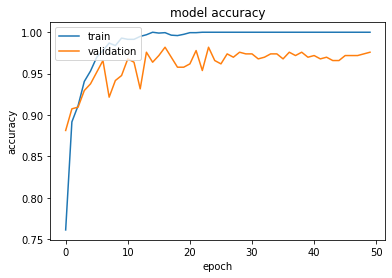

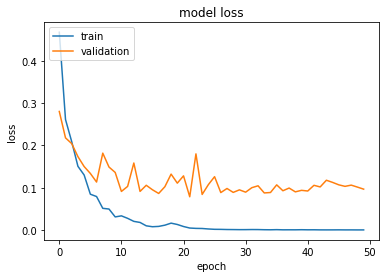

In [ ]:
#  "Accuracy"
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
accu = history1.history['accuracy'],
print(max(accu[0]) ,"at epoch number", (accu.index(max(accu))+1))

1.0 at epoch number 1


In [ ]:
model1.evaluate(test_generator)

16/16 [==============================] - 1s 61ms/step - loss: 0.0965 - accuracy: 0.9759


[0.0965440422296524, 0.9758551120758057]

In [ ]:
#Xception MODEL NO. 1
#from tensorflow.keras.applications import Xception
tmodel_base = Xception(input_shape = input_shape, 
                                include_top = False, 
                                weights = 'imagenet')
for layer in tmodel_base.layers:
    layer.trainable = False

#Getting desired layer output
# Modification of pretrained model
last_layer = tmodel_base.get_layer('block14_sepconv2_act')
last_output = last_layer.output
 
#x = GlobalMaxPooling2D()(last_output)
x = MaxPooling2D(strides=(2,2))(last_output)
x = Flatten()(x)
#x = Dense(1024,activation='relu')(x)
#x = Dropout(0.15)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.15)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.15)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
x = layers.Dense(2, activation='softmax')(x)
#Compiling model
model2 = Model(inputs = tmodel_base.input, outputs = x, name = 'Our_Xception')
model2.summary()

Model: "Our_Xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [ ]:
opt1 = Adam(lr=5e-5, beta_1=0.85, beta_2=0.999)
#opt2 = RMSprop(learning_rate = 0.001)

model2.compile(optimizer = opt1 , loss = 'categorical_crossentropy', metrics = ['accuracy'])
history2 = model2.fit_generator(train_generator, epochs=50, validation_data = test_generator)

Epoch 1/50
62/62 [==============================] - 7s 116ms/step - loss: 0.6030 - accuracy: 0.6895 - val_loss: 0.4103 - val_accuracy: 0.8410
Epoch 2/50
62/62 [==============================] - 6s 103ms/step - loss: 0.4217 - accuracy: 0.8100 - val_loss: 0.3160 - val_accuracy: 0.8612
Epoch 3/50
62/62 [==============================] - 6s 103ms/step - loss: 0.3576 - accuracy: 0.8417 - val_loss: 0.3254 - val_accuracy: 0.8612
Epoch 4/50
62/62 [==============================] - 6s 103ms/step - loss: 0.3115 - accuracy: 0.8664 - val_loss: 0.2576 - val_accuracy: 0.8893
Epoch 5/50
62/62 [==============================] - 6s 103ms/step - loss: 0.2477 - accuracy: 0.8947 - val_loss: 0.2820 - val_accuracy: 0.8773
Epoch 6/50
62/62 [==============================] - 6s 103ms/step - loss: 0.2193 - accuracy: 0.9052 - val_loss: 0.2599 - val_accuracy: 0.8913
Epoch 7/50
62/62 [==============================] - 6s 103ms/step - loss: 0.1937 - accuracy: 0.9234 - val_loss: 0.2219 - val_accuracy: 0.9074
Epoch 

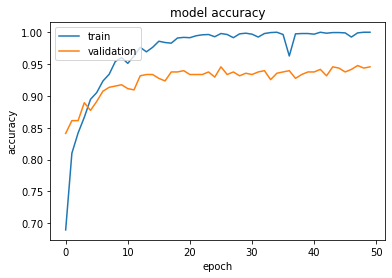

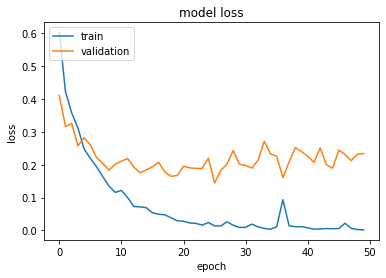

In [ ]:
#  "Accuracy"
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model2.evaluate(test_generator)

16/16 [==============================] - 1s 74ms/step - loss: 0.2339 - accuracy: 0.9457


[0.23391486704349518, 0.9456740617752075]

In [ ]:
accu = history2.history['accuracy'],
print(max(accu[0]) ,"at epoch number", (accu.index(max(accu))+1))

1.0 at epoch number 1


In [ ]:
#ResNet50 MODEL NO. 3
from tensorflow.keras.applications.resnet50 import ResNet50
num_classes=1
tmodel_base = ResNet50(input_shape = input_shape, 
                                include_top = False, 
                                weights = 'imagenet')
for layer in tmodel_base.layers:
    layer.trainable = False

#last_layer = tmodel_base.get_layer('flatten_13')
last = tmodel_base.output


x = Conv2D(1024,(2,2),strides=(1,1))(last)
#x = layers.GlobalMaxPooling2D()(last)
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(rate = 0.15)(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(rate = 0.25)(x)
x = Dense(2, activation = 'softmax')(x)

#Compiling model
model3 = Model(inputs = tmodel_base.input, outputs = x, name = 'Predict')
model3.summary()

Model: "Predict"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
opt1 = Adam(lr=1e-4, beta_1=0.89, beta_2=0.999)
opt2 = RMSprop(learning_rate = 0.001)
model3.compile(optimizer = opt1 , loss = 'categorical_crossentropy', metrics = ['accuracy'])

history3 = model3.fit_generator(train_generator, epochs=50, validation_data = test_generator)

Epoch 1/50
62/62 [==============================] - 7s 106ms/step - loss: 0.1313 - accuracy: 0.9481 - val_loss: 0.2230 - val_accuracy: 0.9215
Epoch 2/50
62/62 [==============================] - 6s 92ms/step - loss: 0.1230 - accuracy: 0.9531 - val_loss: 0.1996 - val_accuracy: 0.9256
Epoch 3/50
62/62 [==============================] - 6s 92ms/step - loss: 0.1427 - accuracy: 0.9405 - val_loss: 0.2271 - val_accuracy: 0.9074
Epoch 4/50
62/62 [==============================] - 6s 92ms/step - loss: 0.1201 - accuracy: 0.9491 - val_loss: 0.1944 - val_accuracy: 0.9336
Epoch 5/50
62/62 [==============================] - 6s 92ms/step - loss: 0.1291 - accuracy: 0.9491 - val_loss: 0.1976 - val_accuracy: 0.9336
Epoch 6/50
62/62 [==============================] - 6s 91ms/step - loss: 0.0919 - accuracy: 0.9612 - val_loss: 0.2376 - val_accuracy: 0.9356
Epoch 7/50
62/62 [==============================] - 6s 92ms/step - loss: 0.1026 - accuracy: 0.9546 - val_loss: 0.2391 - val_accuracy: 0.9296
Epoch 8/50
6

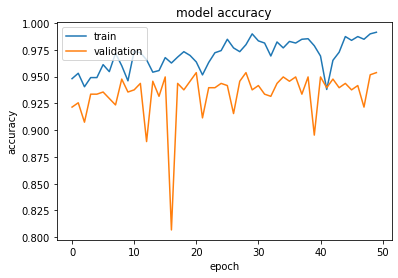

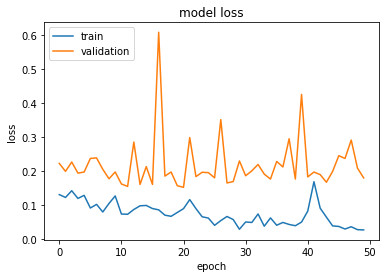

In [ ]:
#  "Accuracy"
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model3.evaluate_generator(test_generator)

[0.18029972910881042, 0.953722357749939]

In [ ]:
#InceptionV3 MODEL NO. 4
from tensorflow.keras.applications.inception_v3 import InceptionV3
num_classes=1
tmodel_base = InceptionV3(input_shape = input_shape, 
                                include_top = False, 
                                weights = 'imagenet')
for layer in tmodel_base.layers:
    layer.trainable = False

last  = tmodel_base.output


#x = Conv2D(600, (1,1), activation = 'relu')(last)
x = Flatten()(last)
#x = Dense(1024, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l1(0.01))(x)
#x = Dropout(rate = 0.1)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(rate = 0.1)(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(rate = 0.25)(x)
x = Dense(2, activation = 'softmax')(x)

#Compiling model
model4 = Model(inputs = tmodel_base.input, outputs = x, name = 'Predict')
model4.summary()

Model: "Predict"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_103 (Conv2D)             (None, 111, 111, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_102 (BatchN (None, 111, 111, 32) 96          conv2d_103[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_102[0][0]    
____________________________________________________________________________________________

In [ ]:
opt1 = Adam(lr=5e-6, beta_1=0.9, beta_2=0.999)
opt2 = RMSprop(learning_rate = 0.001)
model4.compile(optimizer = opt1 , loss = 'categorical_crossentropy', metrics = ['accuracy'])
history4 = model4.fit_generator(train_generator, epochs=50, validation_data = test_generator)



Epoch 1/50
62/62 [==============================] - 6s 89ms/step - loss: 0.6287 - accuracy: 0.6709 - val_loss: 0.4601 - val_accuracy: 0.7827
Epoch 2/50
62/62 [==============================] - 4s 68ms/step - loss: 0.4306 - accuracy: 0.8085 - val_loss: 0.3721 - val_accuracy: 0.8390
Epoch 3/50
62/62 [==============================] - 4s 68ms/step - loss: 0.3480 - accuracy: 0.8619 - val_loss: 0.3292 - val_accuracy: 0.8551
Epoch 4/50
62/62 [==============================] - 4s 68ms/step - loss: 0.2815 - accuracy: 0.8851 - val_loss: 0.2886 - val_accuracy: 0.8612
Epoch 5/50
62/62 [==============================] - 4s 69ms/step - loss: 0.2261 - accuracy: 0.9103 - val_loss: 0.2961 - val_accuracy: 0.8612
Epoch 6/50
62/62 [==============================] - 4s 68ms/step - loss: 0.2084 - accuracy: 0.9219 - val_loss: 0.2520 - val_accuracy: 0.8974
Epoch 7/50
62/62 [==============================] - 4s 68ms/step - loss: 0.1823 - accuracy: 0.9350 - val_loss: 0.2645 - val_accuracy: 0.8873
Epoch 8/50
62

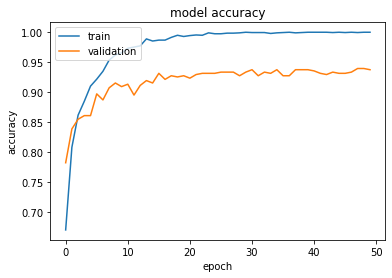

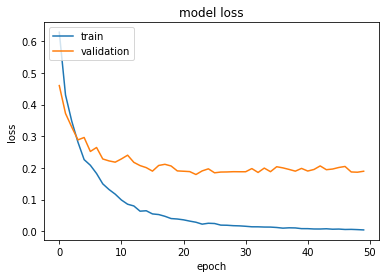

In [ ]:
#  "Accuracy"
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model4.evaluate_generator(test_generator)

[0.18947148323059082, 0.9376257658004761]

In [ ]:
# Save the pre-trained models
model1.save("/content/drive/My Drive/Colab Notebooks/our_vgg16.h5")
model2.save("/content/drive/My Drive/Colab Notebooks/our_xception.h5")
model3.save("/content/drive/My Drive/Colab Notebooks/our_resnet50.h5")
model4.save("/content/drive/My Drive/Colab Notebooks/our_inceptionv3.h5")
